# Assignment 1 for FIT5212, Semester 1

**Student Name:**  Han Li

**Student ID:**  32710542

## Part 1:  Text Classification

General comments and any shared processing here.

## Set up
##### Below block is for loading all libraries required for the project and preliminary set up including device and seed


In [376]:
#For data loading and manipulation
import numpy as np
import pandas as pd

#For data visulisation
%matplotlib inline
import matplotlib.pyplot as plt
#pip install plotly
import plotly.express as px
import plotly as py

#For preprocssing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk
from nltk import PorterStemmer,WordNetLemmatizer,wordpunct_tokenize,word_tokenize
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re

#For Modelling
#pip install xgboost
#pip install lightgbm
from xgboost import XGBClassifier
#import lightgbm as lgb
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#RNN Related
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer 
from collections import Counter
from torchtext.vocab import Vocab

#For performance metrics, data spliting
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix,f1_score,ConfusionMatrixDisplay,
                             precision_score,accuracy_score,
                             recall_score,matthews_corrcoef,precision_recall_curve)

#For Model tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split


#For Topic Modelling
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd
import seaborn as sns

#Utilities
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import random
import os
import re

In [430]:
# Seed for reprodiction
SEED = 23
def seeding(SEED = SEED):
    """SEED: int number define by variable SEED"""
    np.random.seed(SEED)
    random.seed(SEED)
    torch.manual_seed(SEED)
seeding() 

# Setting up cuda for Colab GPU runtime and mps for ARM enviroment
# The code will be test under macos arm with mps support and Colab GPU runtime with cuda support
DEVICE = torch.device('cuda' if 
torch.cuda.is_available() else 'cpu')

In [283]:
#Assert train.csv and test.csv are in working directory
train_dir = (os.getcwd() +'/train.csv' if 'train.csv' in os.listdir() else print('training set not in working directory'))
test_dir = (os.getcwd() +'/test.csv' if 'test.csv' in os.listdir() else print('testing set not in working directory'))

#Load datasets
df_train = pd.read_csv(train_dir)
df_test = pd.read_csv(test_dir)

In [284]:
#Inspect train and test data
df_train.sample(5)
df_test.sample(5)

,title,abstract,InformationTheory,ComputationalLinguistics,ComputerVision
17289,GRADE-AO: Towards Near-Optimal Spatially-Coupl...,Spatially-coupled (SC) codes known for their...,1,0,0
14713,Neural Fields as Learnable Kernels for 3D Reco...,We present Neural Kernel Fields: a novel met...,0,0,1
3532,Investigations on $c$-Boomerang Uniformity and...,We defined in~citeEFRST20 a new multiplicati...,1,0,0
17692,Linear Adversarial Concept Erasure,Modern neural models trained on textual data...,0,1,0
9882,Parsing Free Word-Order Languages in Polynomia...,We present a parsing algorithm with polynomi...,0,1,0


# Preprocessing
## For easy access, I will wrap all necessary steps for preprocessing in 1 single class
#### Step 1: Training,Validation split (df_train_val_split)
##### This is to split the entire training set into training and validation set basic on task requirement


#### Step 2: preprocessing(preprocess) 
##### This is to preprocess the data using 2 different method
##### Method 1: Text to be lower, remove stopword, paranthesis and other special charaters,spaces and apply porter stemmer and tfidf vectorizer
##### Method 2: Text to be lower, remove special charaters,spaces and apply lemmatizer and countvectorizer

#### Step 3:Clean(clean) 
##### This is to combine the above method and apply the cleaning to each input(text) of the datasett

In [296]:
class preprocesser:
    """
    How to use:
    Initialize preprocesser 
    e.g. prep = preporcesser()

    Obtain X,y for training and validation set using only the clean function 
    e.g. X_train,X_val,y_train,y_val = prep.clean(task = 'InformationTheory',size = 'sample',
                                                input = 'abstract',method = 2)
    """

    class LemmaTokenizer(object):
        def __init__(self):
            self.wnl = WordNetLemmatizer()

        def __call__(self, doc):
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


    class SteamTokenizer(object):
        def __init__(self):
            self.ps = PorterStemmer()

        def __call__(self, doc):
            return [self.ps.stem(t) for t in word_tokenize(doc)]
        
    def __init__(self):
        self.df = df_train
        self.df_test = df_test
        self.lemma = self.LemmaTokenizer()
        self.steam  = self.SteamTokenizer()

        self.stem_vectorizer = TfidfVectorizer(
                                  tokenizer=self.steam)
        self.LemmaTokenizer = CountVectorizer(
            tokenizer=self.lemma
)

    def df_train_val_split(self, Text, Label, Size):
        
        """
        Text:Dependent variables can be choose from ['InformationTheory','ComputationalLinguistics','ComputerVision']

        Label:independent variable that can be choose from ['title','abstract']

        Size = select from ['full','sample'] to return either 10% or entire training set

        df_train_1k, df_val_1k: The first 1000 sample of the df_train set(900 inputs), and split 10% as validation set(100 inputs)

        df_train_all, df_val_all: The entire training data(112500 inputs) excluding 10% as validation set(12500 inputs)

        Return: X_train,X_val,y_train,y_val the training and validation value as list for both X and y variables
        """
        # Assert inputs meets function requirement
        assert Text in [
            'title', 'abstract'], 'Please ensure input is choosen from title and abstract'
        assert Label in ['InformationTheory', 'ComputationalLinguistics',
                        'ComputerVision'], 'Please ensure column name you wish to predict are correct'
        assert Size in ['full', 'sample'], 'choose only full or sample dataset'
        np.random.RandomState(SEED) 
        if Size == 'sample':
            df_1k = self.df.sample(1000).reset_index(drop=True)
            df_train_1k, df_val_1k = train_test_split(df_1k, test_size=.1)
            X_train = df_train_1k[Text].tolist()
            X_val = df_val_1k[Text].tolist()
            y_train = df_train_1k[Label].tolist()
            y_val = df_val_1k[Label].tolist()
            
            

        elif Size == 'full':
            df_train_all, df_val_all = train_test_split(self.df, test_size=.1)
            X_train = df_train_all[Text].tolist()
            X_val = df_val_all[Text].tolist()
            y_train = df_train_all[Label].tolist()
            y_val = df_val_all[Label].tolist()

        X_test = self.df_test[Text].tolist()
        y_test = self.df_test[Label].tolist()
        return X_train, X_val, X_test,y_train,y_val,y_test


    def preprocess(self,text,Method = 1):
        """
        text :raw text from dataset input
        method: int 1 or 2, refer to differetn preprocessing method
        Method 1: Text to be lower, remove stopword, paranthesis and other special charaters,spaces and apply porter stemmer and tfidf vectorizer
        Method 2:  Remove special charaters,spaces and apply lemmatizer and countvectorizer
        """
        assert Method in [1,2],'Please select 1 or 2 only'
        STOPWORDS = set(stopwords.words('english'))

        
        # Remove Special characters \n
        text = re.sub(r'\n','',text)
        text = re.sub(' +', ' ', text)  # remove multiple spaces
        text = text.strip() 

        if Method == 1:
            # Lower
            text = text.lower()
            # remove non alphanumeric chars
            text = re.sub('[^A-Za-z0-9]+', ' ', text)
            # Remove stopwords
            pattern = re.compile(r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*')
            text = pattern.sub('', text)
            # Remove words in paranthesis
            text = re.sub(r'\([^)]*\)', '', text)

        else:
            # Removing punctuations,underscrore '_'
            text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)

        return text
    
    def clean(self,Text,Size,Label,Method):
        """
        Task,input,size = require argument for df_train_val_split
        method = require argument ofr preprocess
        """
        X_train, X_val, X_test,y_train,y_val,y_test= self.df_train_val_split(Text,Label,Size)

        if Method == 1:
            X_train = [self.preprocess(i,Method =1 ) for i in X_train]
            X_train = self.stem_vectorizer.fit_transform(X_train).astype(np.float64)
            X_val = [self.preprocess(i,Method =1) for i in X_val]
            X_val = self.stem_vectorizer.transform(X_val).astype(np.float64)
            X_test = [self.preprocess(i,Method =1 ) for i in X_test]
            X_test = self.stem_vectorizer.transform(X_test).astype(np.float64)
        elif Method == 2:
            X_train = [self.preprocess(i,Method =2 ) for i in X_train]
            X_train = self.LemmaTokenizer.fit_transform(X_train).astype(np.float64)
            X_val = [self.preprocess(i,Method =2 ) for i in X_val]
            X_val = self.LemmaTokenizer.transform(X_val).astype(np.float64)
            X_test = [self.preprocess(i,Method =2 ) for i in X_test]
            X_test = self.LemmaTokenizer.transform(X_test).astype(np.float64)
        y_train = np.asarray(y_train)
        y_val =np.asanyarray(y_val)
        y_test=np.asanyarray(y_test)
        return X_train, X_val, X_test,y_train,y_val,y_test

## Training

### Part 1A: Statistical Method

##### All functions are wrapped in class training as above
#### Step 1: Model Selection(model_selection)
##### Using accuracy as metric, I will run a k fold cross validation for each model in the model dictionary, and return the best model base on the average accuracy over the k runs

#### Step 2: Fine Tuning (fine_tuning) 
##### Using the best model from step 1, this function will conduct a grid serach to fine the best parameter of the best model. Returing a predition of y, i.e. y_pred
##### Improvement: To reduce runtime, we will only choose the most accuracy model from sample set and run it in testing set and full set

#### Step 3:Drawing the Confusion Matrix and Precision recall curve (draw_metrix) 
##### This is draw the confusion matrix and PR Curve between y_pred and y_true. Also display the f1,precison,recall and accuracy score

In [286]:
class training:
    """
    How to use:
    Initialize training 
    e.g. train = training()

    Using draw_metric it will automatecally draw the Confusion matrix and precision recall curve
    your can also assign y_pred to it to obtain the prediction y
    e.g. y_pred = tra.draw_metric(CV = 2,X = X_train,Y = y_train, X_val = X_val,y_val = y_val,
                                i = i,m = m,t = t,s =s)
    
    """
    def __init__(self):
        """
        In here we also defined 2 dictionals to locate the require model and parameter as needed
        """
        self.models = {
    'XGBClassifier': XGBClassifier(),
    'SVM':SVC(),
    'BAGGING':BaggingClassifier()}
        
        self.param_grid = {
        'XGBClassifier': {
            'learning_rate': np.arange(0.001, 1, 0.05),
            'subsample': np.arange(0, 1, 0.3),
            'colsample_bytree': np.arange(0, 1, 0.3),
            'learning_rate':np.arange(0.0001,0.1,0.05)

        },
        'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
        },
         'BAGGING': {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.75, 1.0],
        'max_features': [0.5, 0.75, 1.0],
        'bootstrap': [True, False]
    }
        
        }

    def model_selection(self,CV,X_train,y_train):
        """
        CV:number of Cross validation
        NEED TO FIX
        """
        cv_df = pd.DataFrame(index = range(CV *len(self.models)))
        entries = []
        for mod_name,model in self.models.items():
            f1 = cross_val_score(model,X_train,y_train,scoring = 'f1',cv = CV)
            for cv_idx,f1 in enumerate(f1):
                entries.append((mod_name,cv_idx,f1))
        cv_df  = pd.DataFrame(entries,columns=['model_name', 'fold_idx', 'f1'])
        best_model_name = cv_df.groupby('model_name')['f1'].std().sort_values(ascending=False).index[0]
        return best_model_name
    
    def fine_tuning(self,CV,best_model_name,X_val,y_val):
        """ 
        CV:number of Cross validation
        X_train,y_train,X_val,y_val,X_test,y_test: tarining,validation and testing set respectively
        """
        randomized_scv = RandomizedSearchCV(
            estimator=self.models[best_model_name],
            param_distributions = self.param_grid[best_model_name],
            n_iter = 10,
            scoring= 'accuracy',
            cv = CV,
            random_state= 1,
            n_jobs = -1
        ).fit(X_val,y_val)
        best_model_tuned = randomized_scv.best_estimator_
        #best_model.fit(X_val,y_val)
        #y_pred = best_model.predict(X_test)
        return best_model_tuned
    
    def draw_metric(self,best_model_tuned,X_val,y_val,X_test,y_test ,t= None,m = None,l = None,s =None):
        #best_model_tuned = self.fine_tuning(CV,X_train,y_train,X_val,y_val,X_test,y_test)
        best_model_tuned.fit(X_val,y_val)
        y_pred = best_model_tuned.predict(X_test)
        print(f"The F1 Score for this setting is {f1_score(y_test,y_pred):.3f}")
        print(f"The recall for this setting is {recall_score(y_test,y_pred):.3f}")
        print(f"The Precision for this setting is {precision_score(y_test,y_pred):.3f}")
        print(f"The accuracy for this setting is {accuracy_score(y_test,y_pred):.3f}")
        
        cm = confusion_matrix(y_test,y_pred)
        fig,(ax1,ax2) = plt.subplots(1,2,figsize = (15,5))
        if l != None:
            fig.suptitle(f"Text: {t} Method: {m}, Label: {l}, Size: {s}")
        ax1.imshow(cm,cmap = 'Spectral')
        ax1.set_title('Confusion Matrix')
        ax1.set_xlabel('Predicted Label')
        ax1.set_ylabel('True Label')
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax1.text(j, i, str(cm[i, j]), ha='center', va='center')
        ax1.grid(False)
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        ax2.fill_between(recall, precision)
        ax2.set_ylabel("Precision")
        ax2.set_xlabel("Recall")
        ax2.set_title("Precision-Recall curve")
        ax2.plot(recall,precision)
        plt.tight_layout()
        plt.show()
        return y_pred

#### Model Selection
Using F1 as the socring metric, I iter the model selection method over all combination for sample size and count which model returned as best model the most. We will then tune only this model

In [7]:
tr =  training()
prep = preprocesser()
text = ['title', 'abstract']
method = [1,2]
label = ['InformationTheory', 'ComputationalLinguistics','ComputerVision']
size = ['sample']
model_counter = {}
for t in text:
    for m in method:
        for l in label:
            for s in size:
                X_train, X_val, X_test,y_train,y_val,y_test= prep.clean(Text =t ,Method = m,Label = l,Size =s)
                best_model_name = tr.model_selection(CV = 5 ,X_train = X_train,y_train = y_train)
                if best_model_name not in model_counter.keys():
                    model_counter[best_model_name] = 1
                else:
                    model_counter[best_model_name] +=1


In [8]:
model_counter

{'BAGGING': 3, 'SVM': 5, 'XGBClassifier': 4}

Following above,we will be using SVM as our main prediction model

################################################################################
ITER START
Iter1 Text: title, Label: InformationTheory, Size: sample, Method: 1
The F1 Score for this setting is 0.552
The recall for this setting is 0.388
The Precision for this setting is 0.956
The accuracy for this setting is 0.704


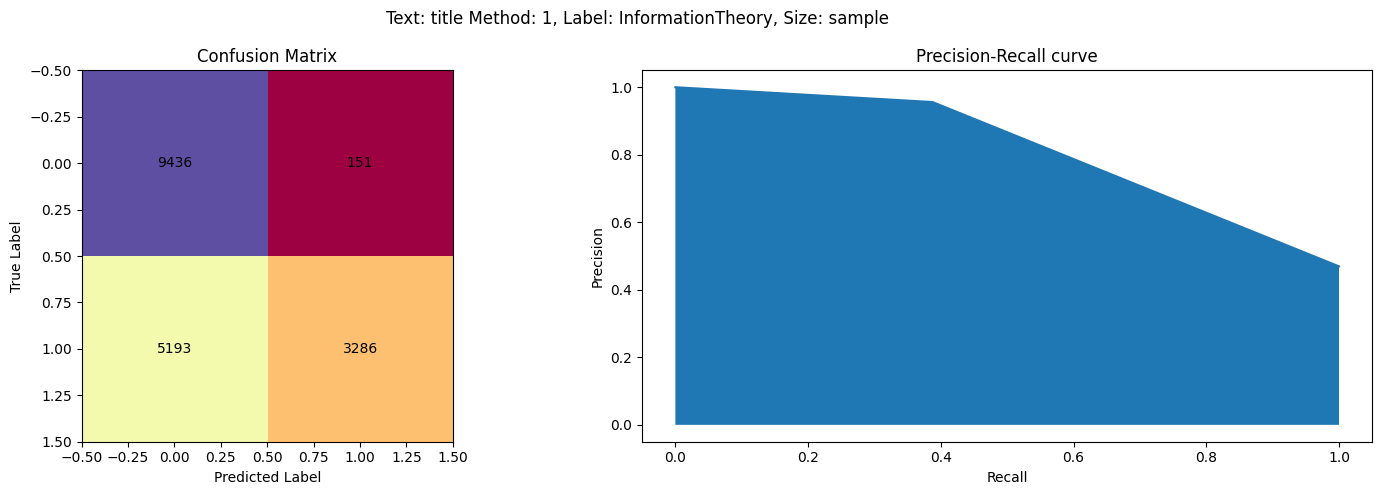

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter2 Text: title, Label: InformationTheory, Size: full, Method: 1
The F1 Score for this setting is 0.897
The recall for this setting is 0.828
The Precision for this setting is 0.978
The accuracy for this setting is 0.910


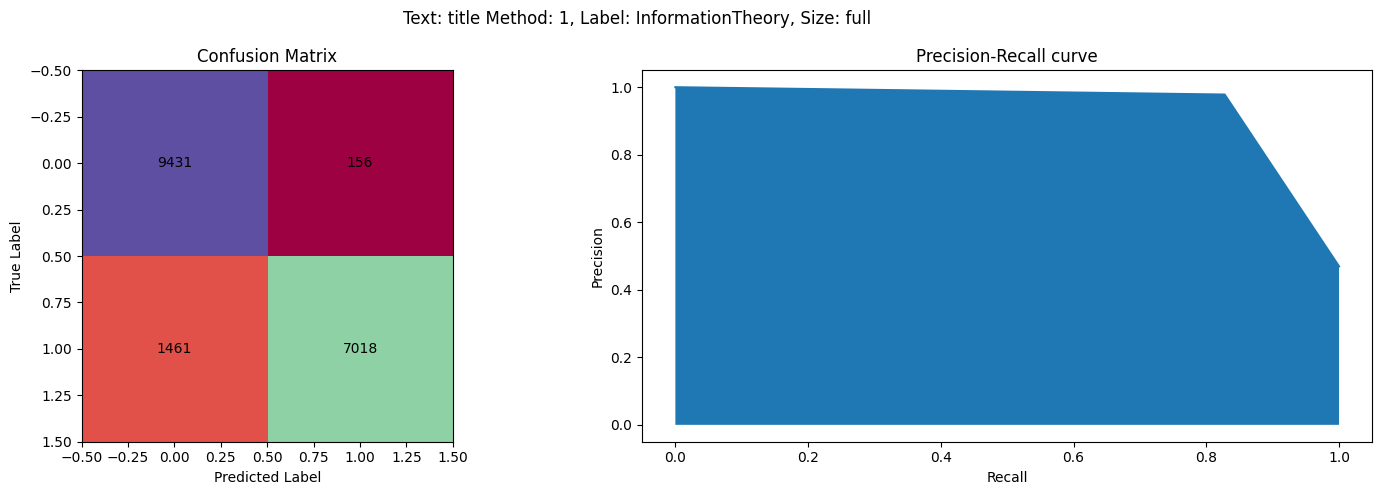

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter3 Text: title, Label: ComputationalLinguistics, Size: sample, Method: 1
The F1 Score for this setting is 0.000
The recall for this setting is 0.000
The Precision for this setting is 0.000
The accuracy for this setting is 0.814


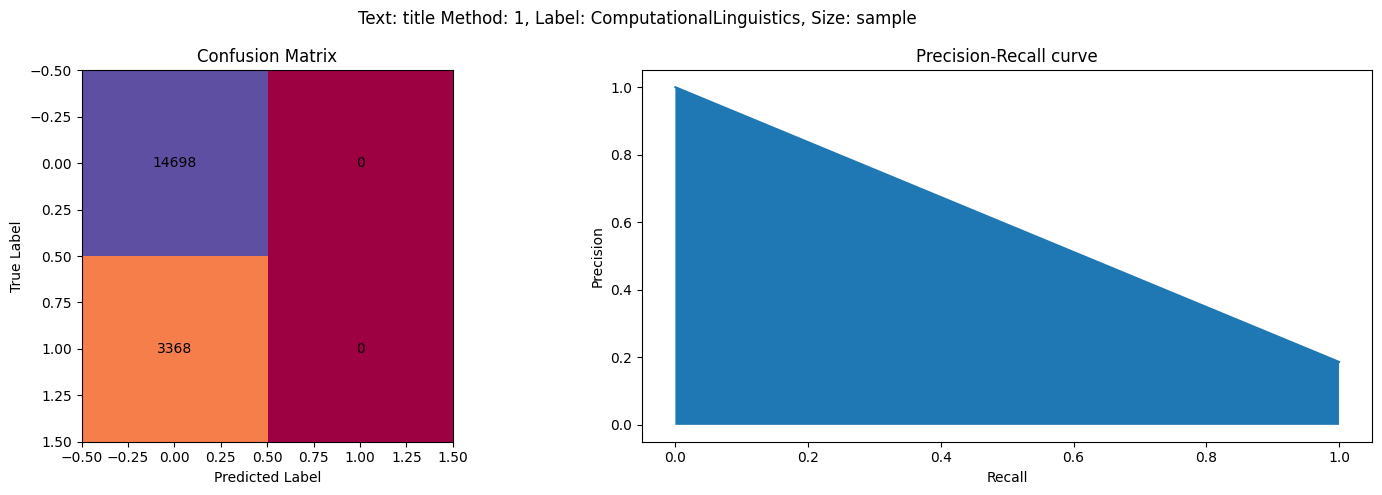

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter4 Text: title, Label: ComputationalLinguistics, Size: full, Method: 1
The F1 Score for this setting is 0.822
The recall for this setting is 0.777
The Precision for this setting is 0.872
The accuracy for this setting is 0.937


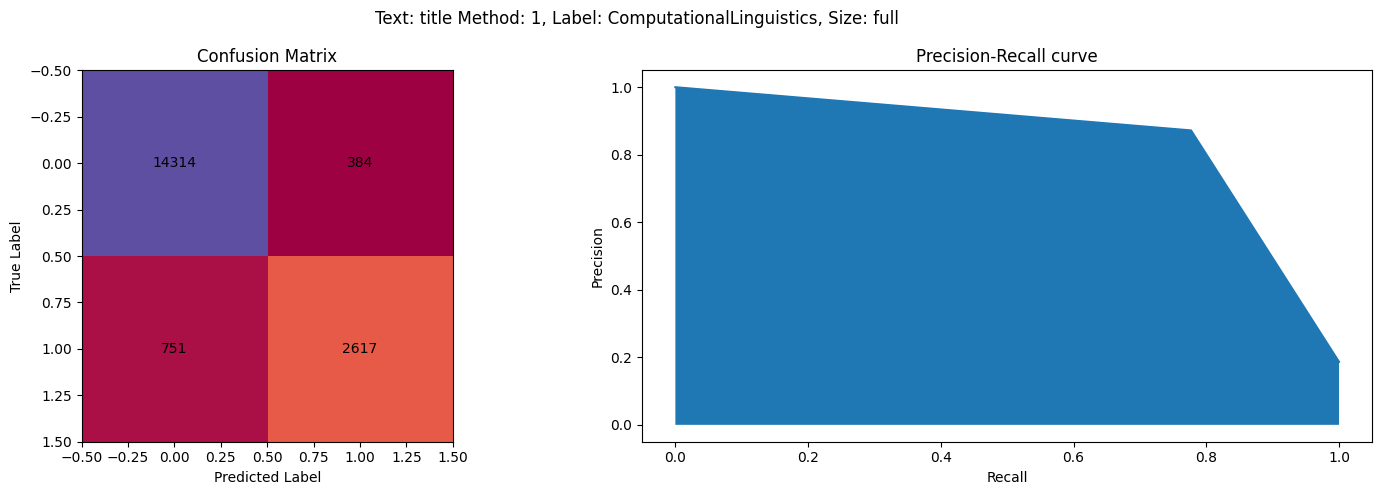

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter5 Text: title, Label: ComputerVision, Size: sample, Method: 1
The F1 Score for this setting is 0.705
The recall for this setting is 0.783
The Precision for this setting is 0.641
The accuracy for this setting is 0.774


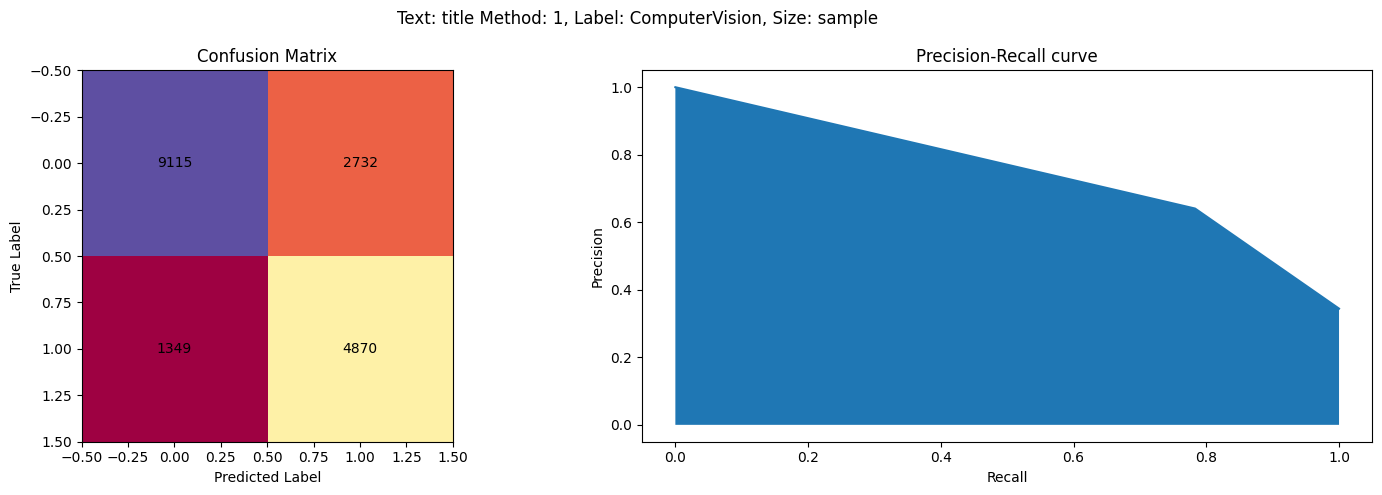

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter6 Text: title, Label: ComputerVision, Size: full, Method: 1
The F1 Score for this setting is 0.880
The recall for this setting is 0.910
The Precision for this setting is 0.851
The accuracy for this setting is 0.914


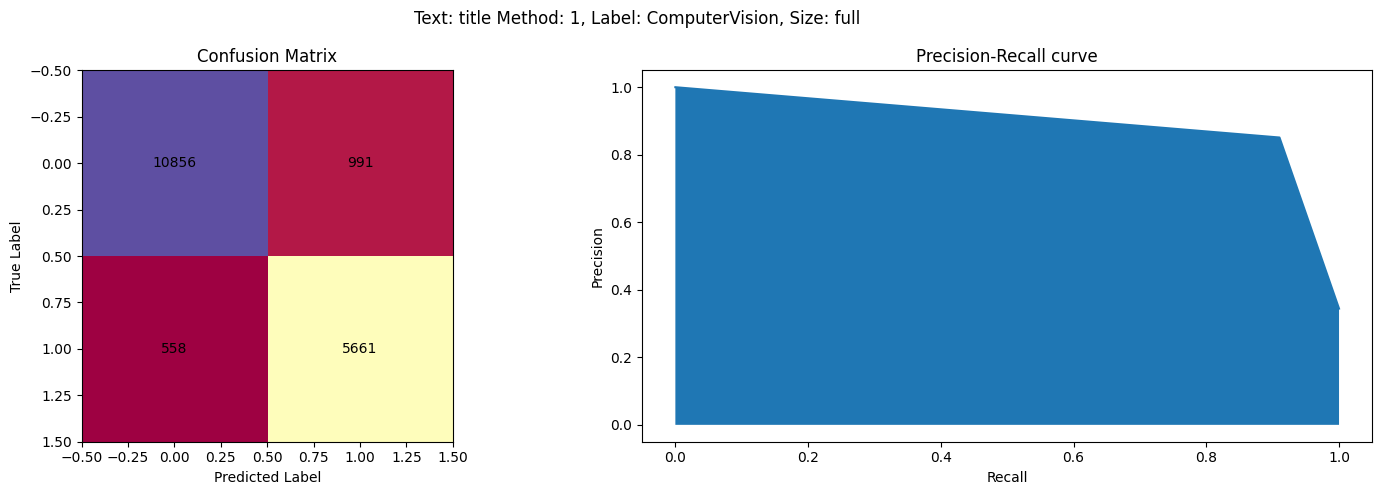

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter7 Text: title, Label: InformationTheory, Size: sample, Method: 2
The F1 Score for this setting is 0.442
The recall for this setting is 0.286
The Precision for this setting is 0.975
The accuracy for this setting is 0.661


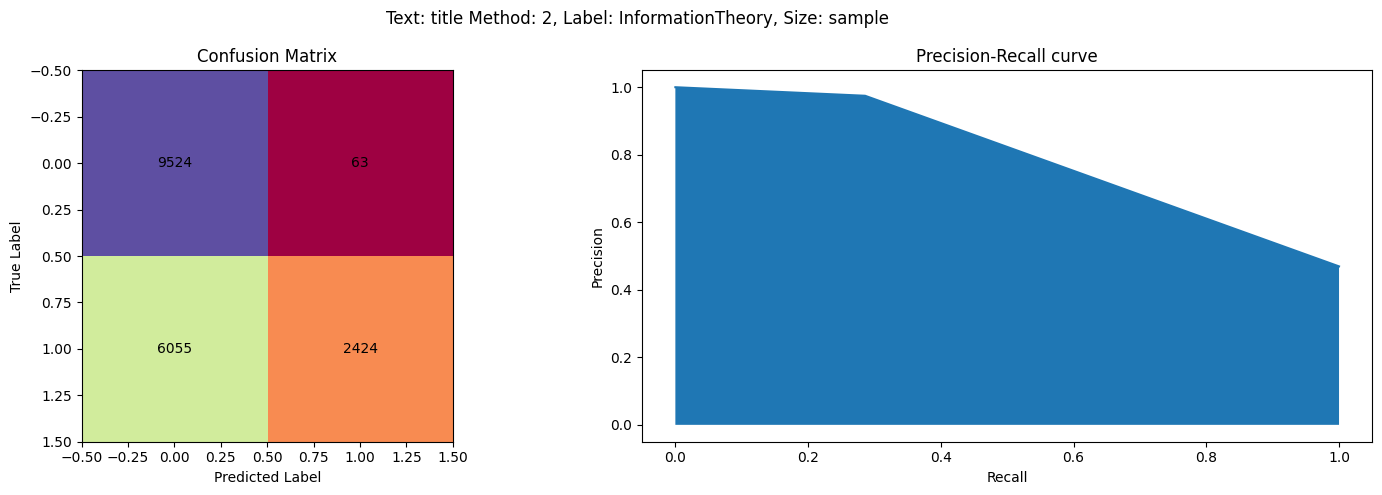

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter8 Text: title, Label: InformationTheory, Size: full, Method: 2
The F1 Score for this setting is 0.891
The recall for this setting is 0.819
The Precision for this setting is 0.977
The accuracy for this setting is 0.906


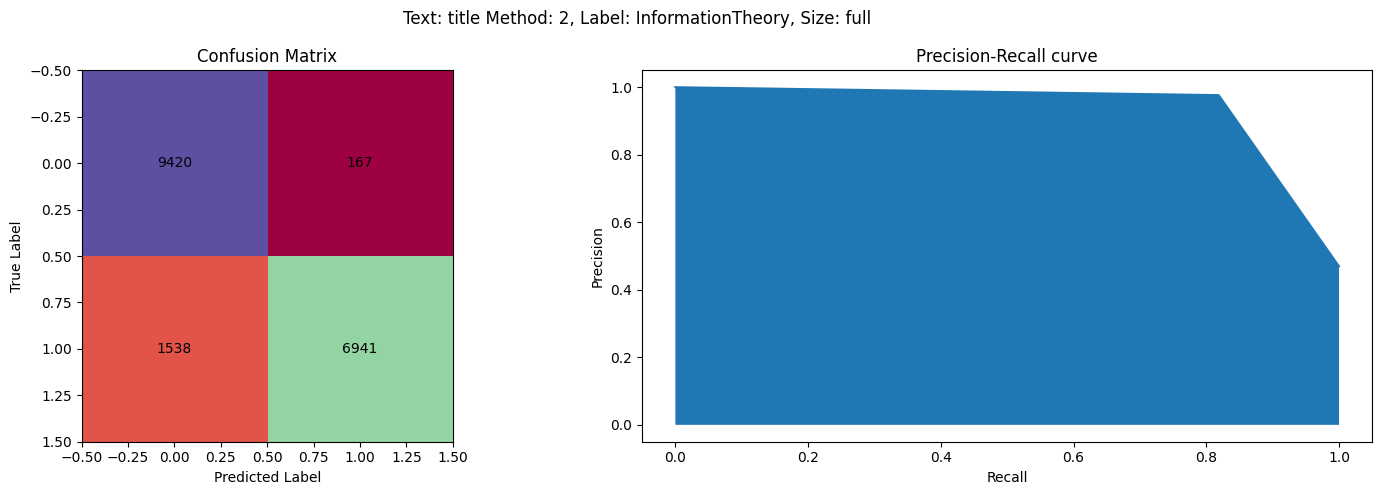

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter9 Text: title, Label: ComputationalLinguistics, Size: sample, Method: 2
The F1 Score for this setting is 0.444
The recall for this setting is 0.404
The Precision for this setting is 0.493
The accuracy for this setting is 0.811


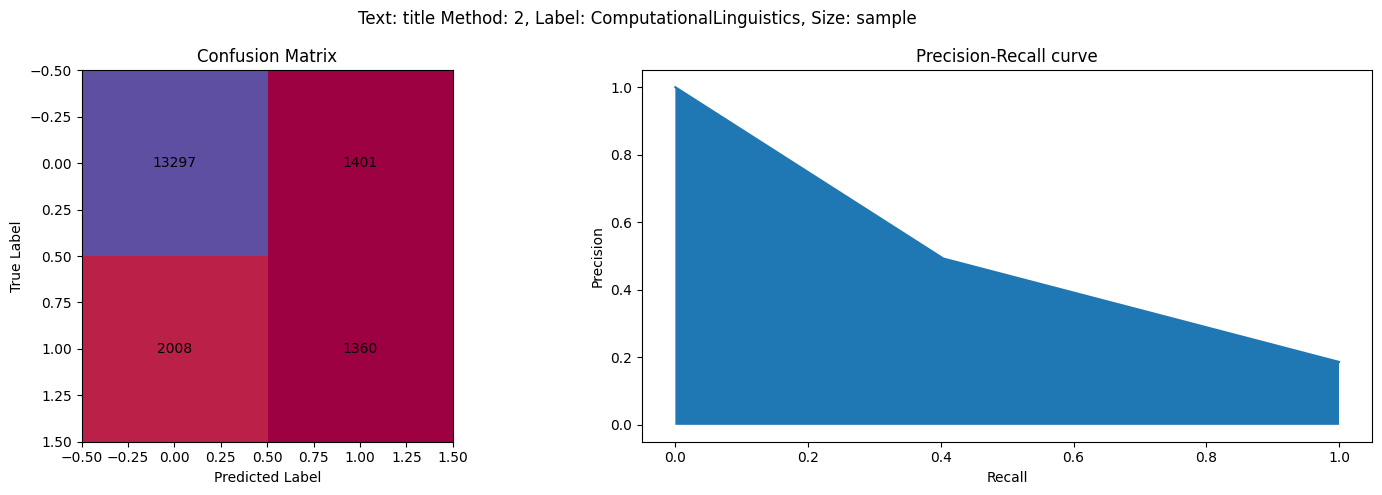

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter10 Text: title, Label: ComputationalLinguistics, Size: full, Method: 2
The F1 Score for this setting is 0.781
The recall for this setting is 0.704
The Precision for this setting is 0.876
The accuracy for this setting is 0.926


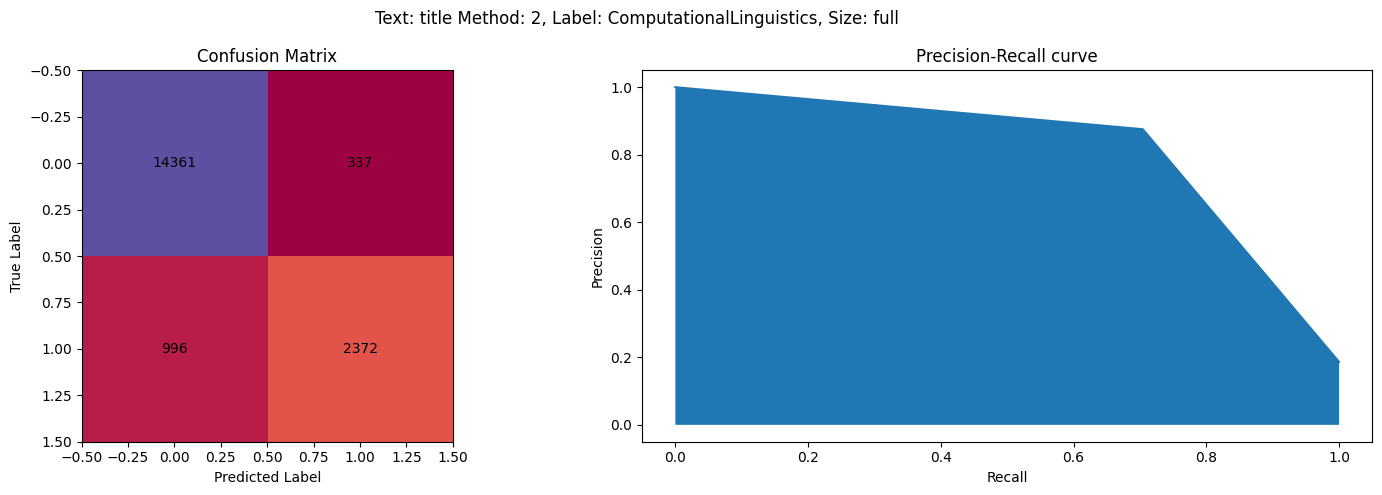

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter11 Text: title, Label: ComputerVision, Size: sample, Method: 2
The F1 Score for this setting is 0.636
The recall for this setting is 0.562
The Precision for this setting is 0.734
The accuracy for this setting is 0.779


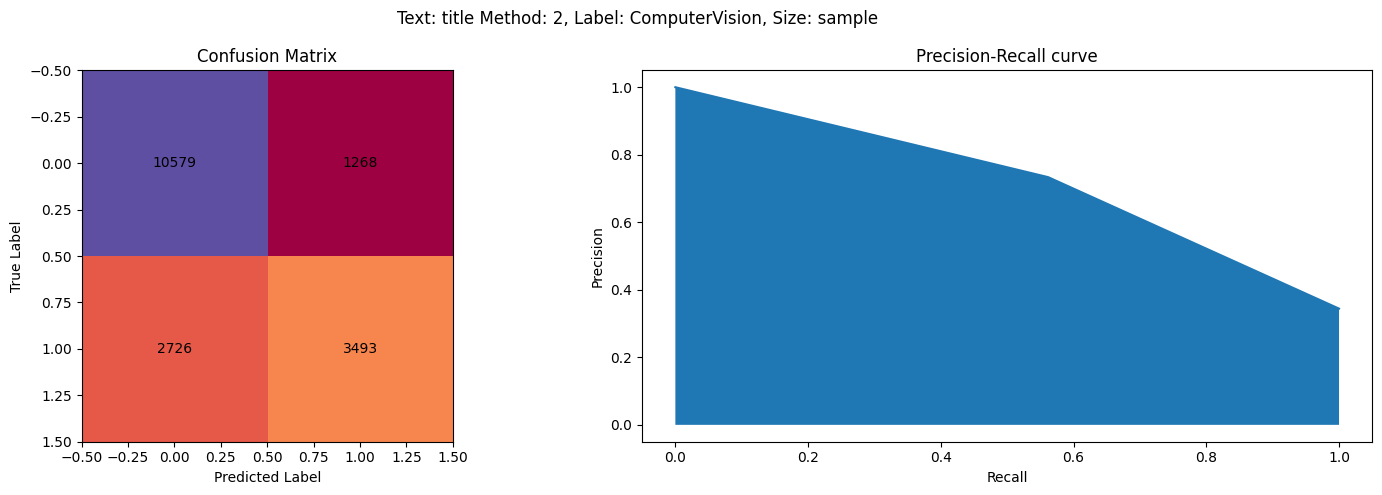

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter12 Text: title, Label: ComputerVision, Size: full, Method: 2
The F1 Score for this setting is 0.877
The recall for this setting is 0.905
The Precision for this setting is 0.850
The accuracy for this setting is 0.913


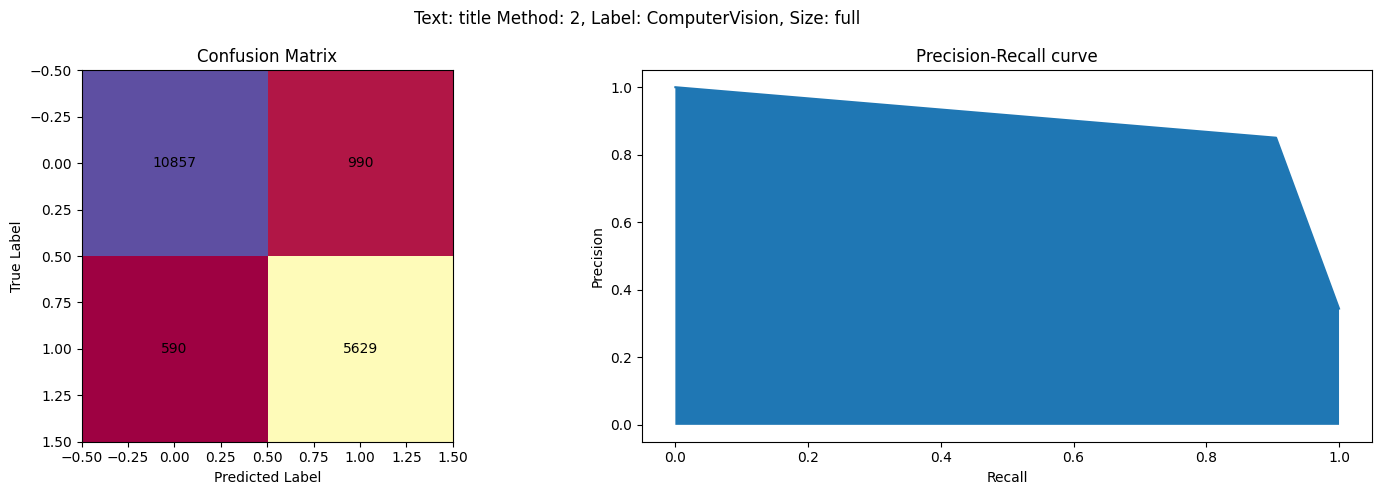

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter13 Text: abstract, Label: InformationTheory, Size: sample, Method: 1
The F1 Score for this setting is 0.674
The recall for this setting is 0.509
The Precision for this setting is 0.995
The accuracy for this setting is 0.769


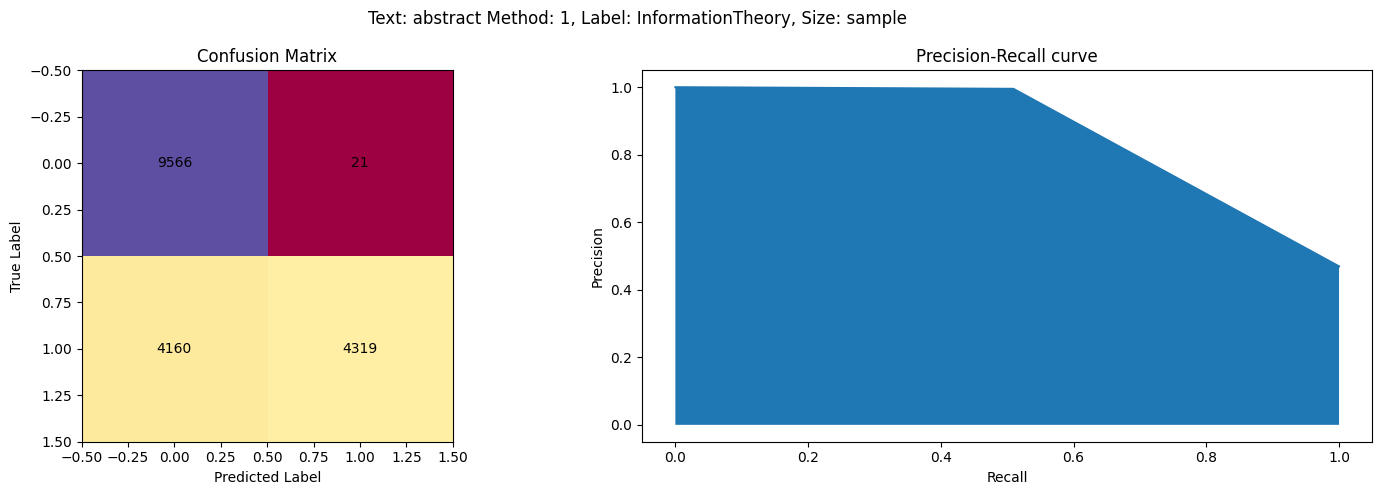

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter14 Text: abstract, Label: InformationTheory, Size: full, Method: 1
The F1 Score for this setting is 0.945
The recall for this setting is 0.910
The Precision for this setting is 0.983
The accuracy for this setting is 0.950


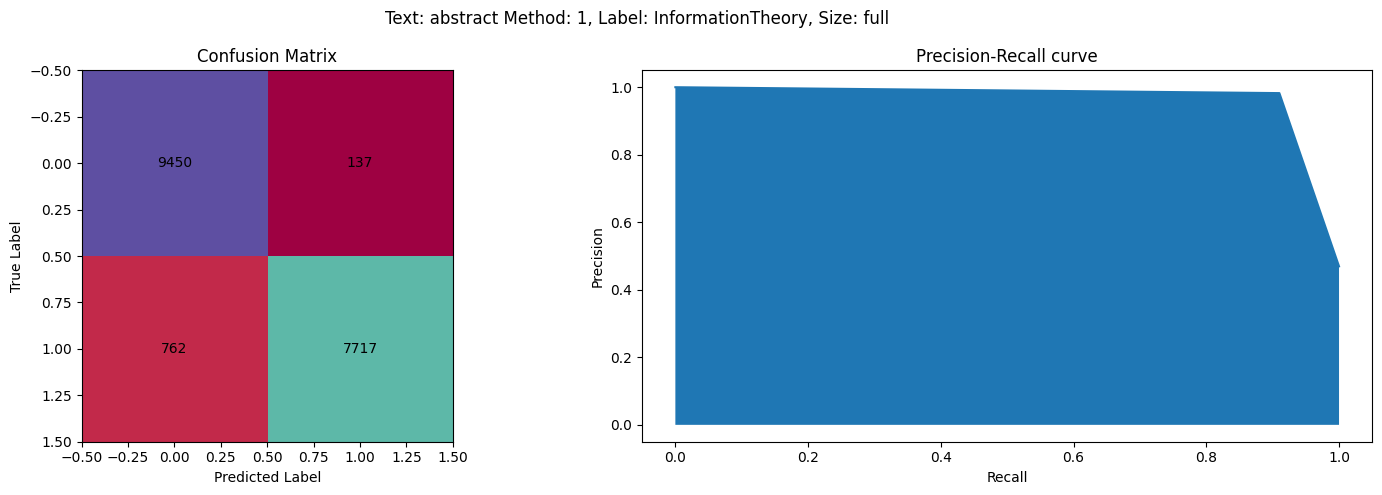

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter15 Text: abstract, Label: ComputationalLinguistics, Size: sample, Method: 1
The F1 Score for this setting is 0.526
The recall for this setting is 0.367
The Precision for this setting is 0.926
The accuracy for this setting is 0.877


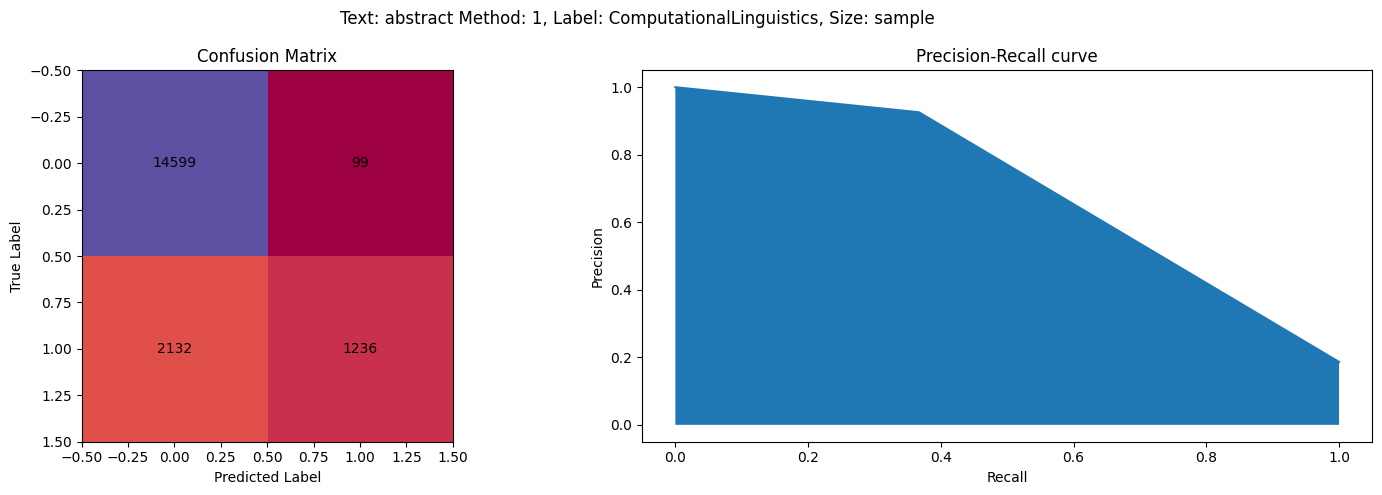

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter16 Text: abstract, Label: ComputationalLinguistics, Size: full, Method: 1
The F1 Score for this setting is 0.886
The recall for this setting is 0.863
The Precision for this setting is 0.910
The accuracy for this setting is 0.959


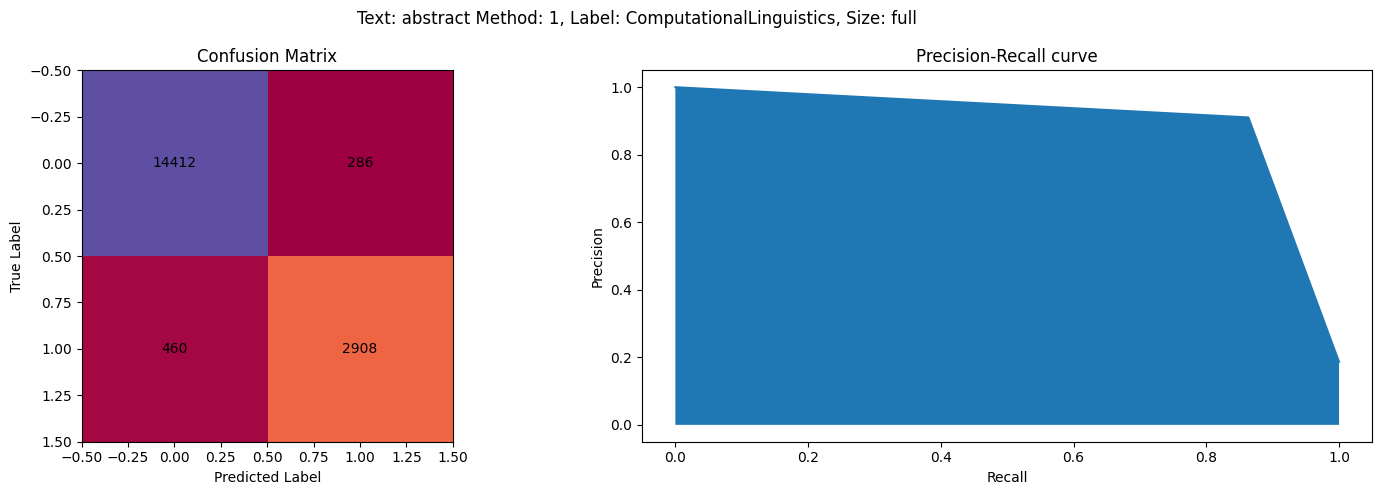

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter17 Text: abstract, Label: ComputerVision, Size: sample, Method: 1
The F1 Score for this setting is 0.841
The recall for this setting is 0.857
The Precision for this setting is 0.825
The accuracy for this setting is 0.888


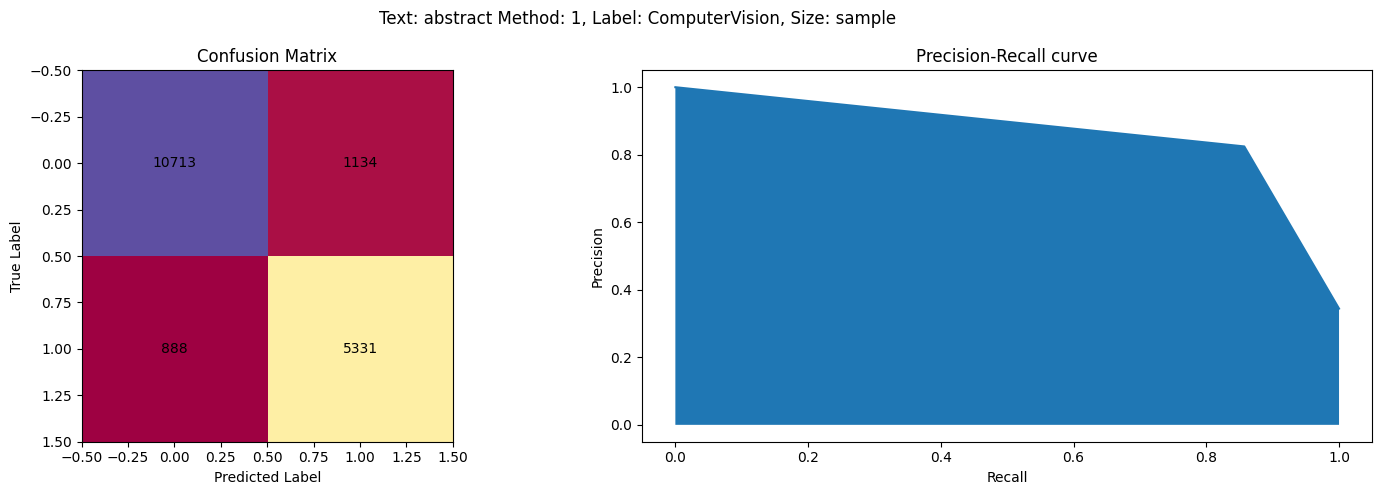

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter18 Text: abstract, Label: ComputerVision, Size: full, Method: 1
The F1 Score for this setting is 0.923
The recall for this setting is 0.943
The Precision for this setting is 0.904
The accuracy for this setting is 0.946


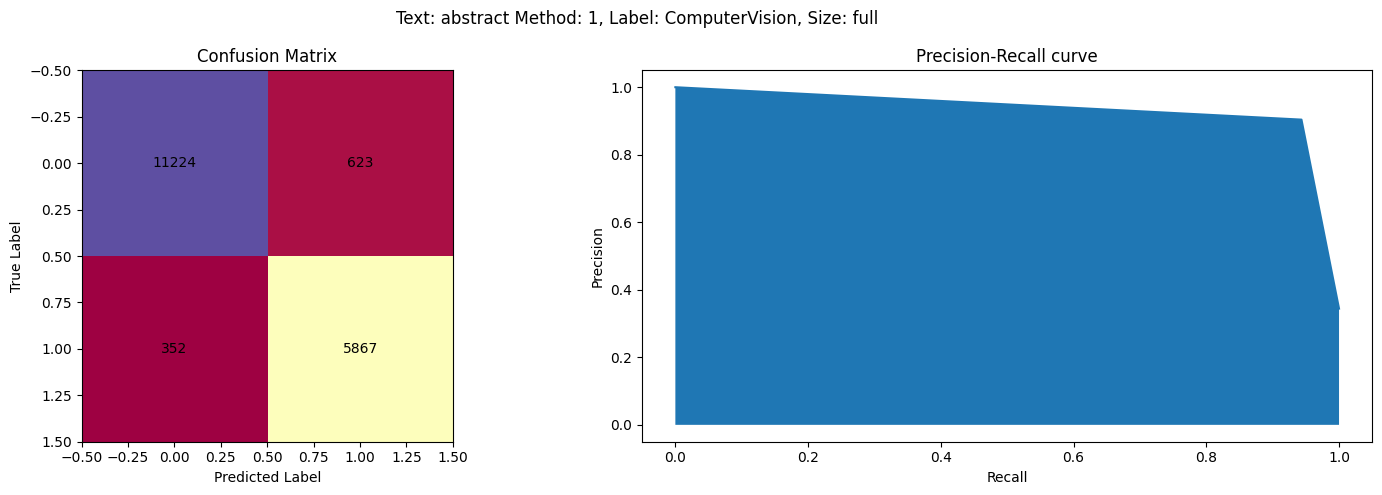

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter19 Text: abstract, Label: InformationTheory, Size: sample, Method: 2
The F1 Score for this setting is 0.660
The recall for this setting is 0.502
The Precision for this setting is 0.962
The accuracy for this setting is 0.757


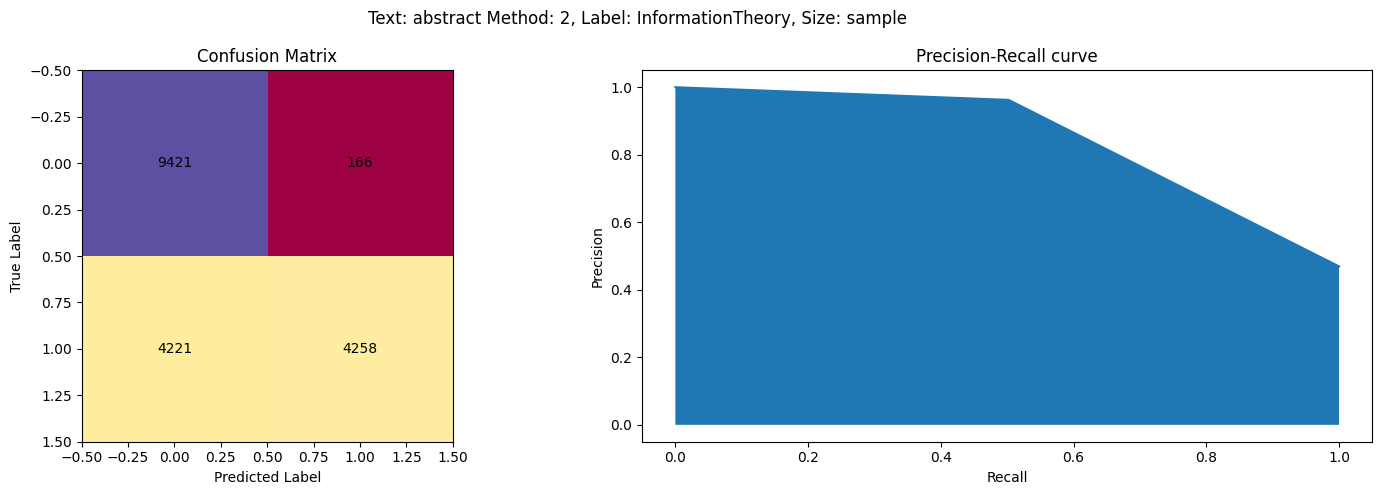

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter20 Text: abstract, Label: InformationTheory, Size: full, Method: 2
The F1 Score for this setting is 0.942
The recall for this setting is 0.911
The Precision for this setting is 0.975
The accuracy for this setting is 0.947


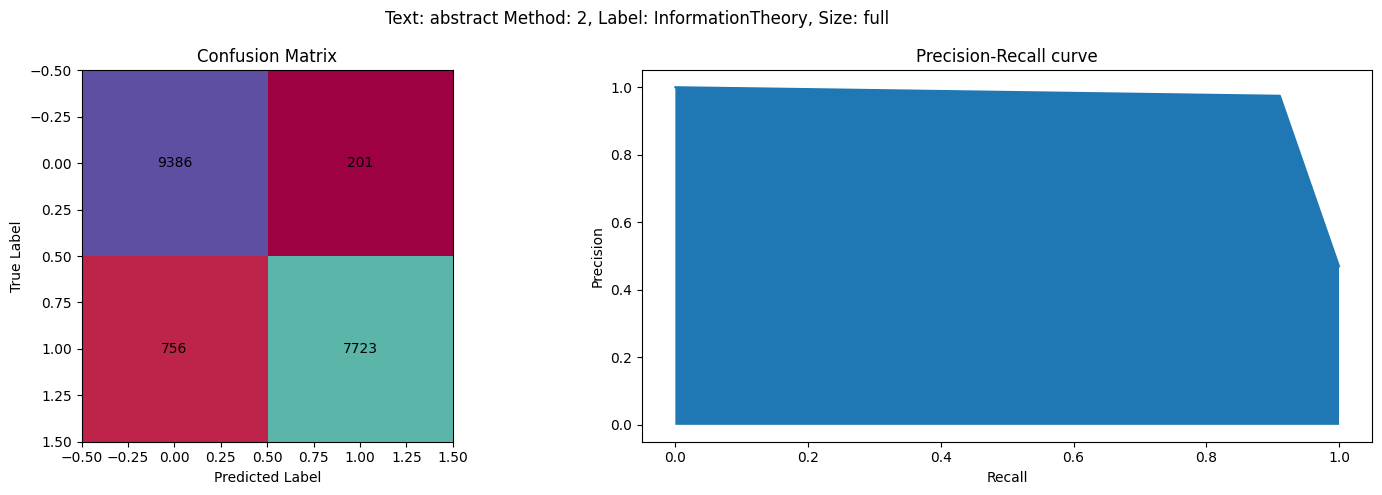

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter21 Text: abstract, Label: ComputationalLinguistics, Size: sample, Method: 2
The F1 Score for this setting is 0.449
The recall for this setting is 0.363
The Precision for this setting is 0.590
The accuracy for this setting is 0.834


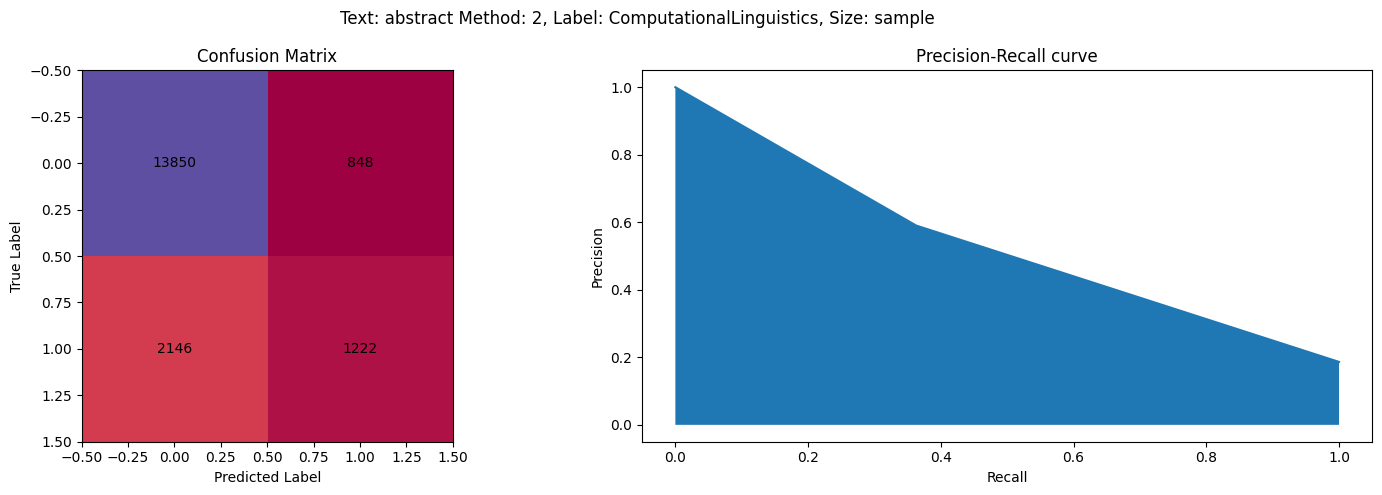

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter22 Text: abstract, Label: ComputationalLinguistics, Size: full, Method: 2
The F1 Score for this setting is 0.861
The recall for this setting is 0.824
The Precision for this setting is 0.902
The accuracy for this setting is 0.951


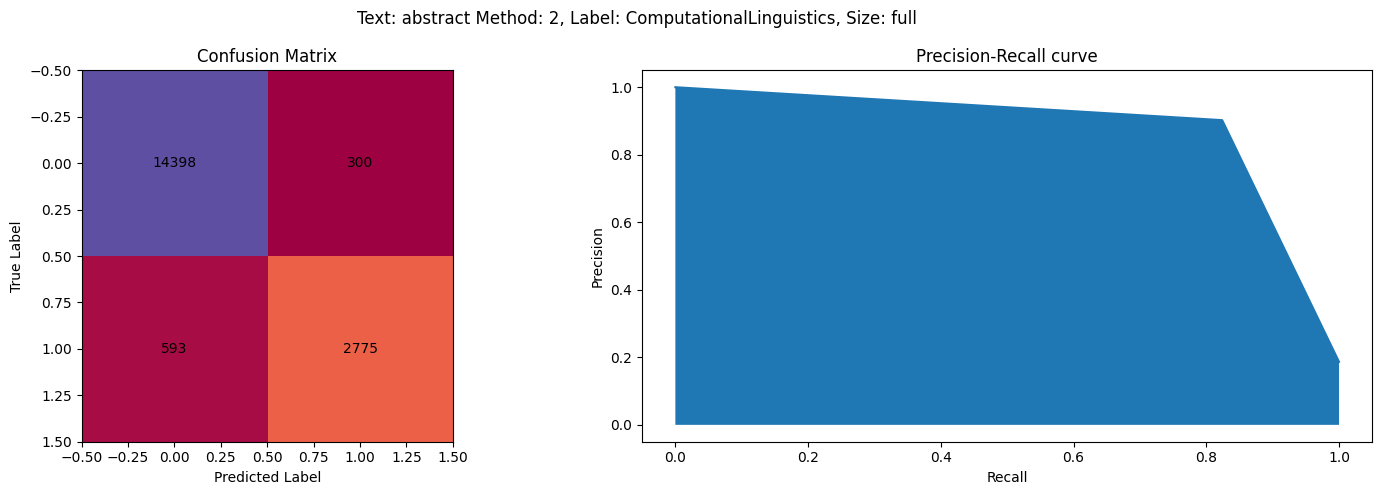

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter23 Text: abstract, Label: ComputerVision, Size: sample, Method: 2
The F1 Score for this setting is 0.738
The recall for this setting is 0.820
The Precision for this setting is 0.671
The accuracy for this setting is 0.800


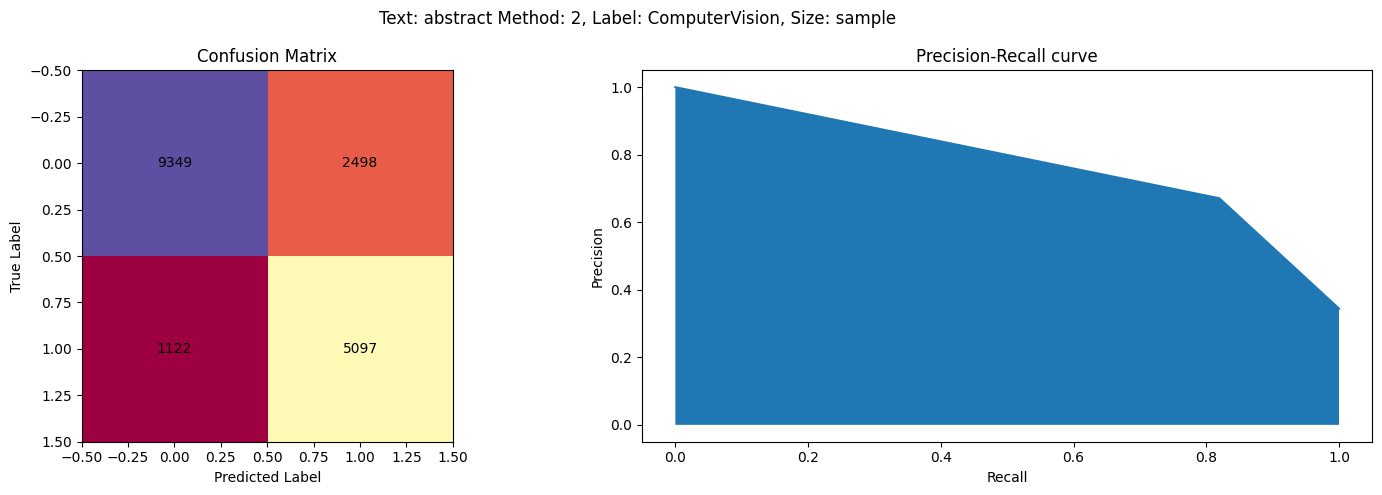

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                
################################################################################
ITER START
Iter24 Text: abstract, Label: ComputerVision, Size: full, Method: 2
The F1 Score for this setting is 0.917
The recall for this setting is 0.941
The Precision for this setting is 0.893
The accuracy for this setting is 0.941


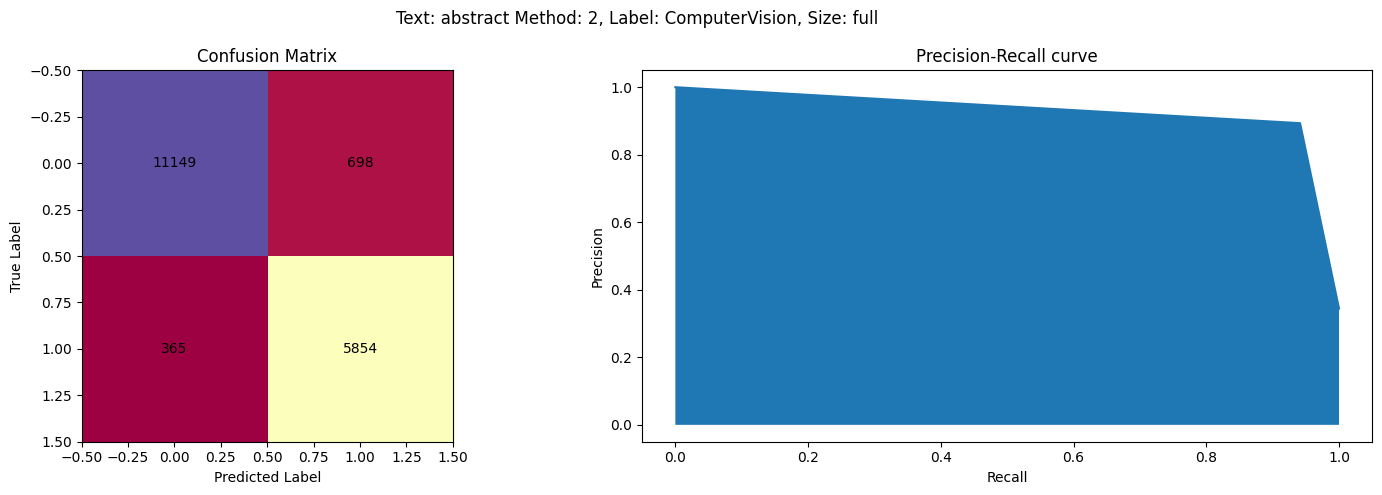

ITER FINISH
################################################################################
                                                                                                                                                                                                                                                


In [9]:
#  lots of Python code here
Text = ['title', 'abstract']
Method = [1,2]
Label = ['InformationTheory', 'ComputationalLinguistics','ComputerVision']
Size = ['sample','full']
Round = 0
results_df = pd.DataFrame()
best_model_name = max(model_counter,key = model_counter.get)
for t in Text:
    for m in Method:
        for l in Label:
            for s in Size:
                Round+=1
                X_train, X_val, X_test,y_train,y_val,y_test= prep.clean(Text = t,Method = m,Label = l,Size =s)
                print('#' * 80)
                print('ITER START')
                print(f"Iter{Round} Text: {t}, Label: {l}, Size: {s}, Method: {m}")
                best_model_tuned = tr.fine_tuning(CV = 5 ,best_model_name=best_model_name,X_val= X_val,y_val = y_val)
                y_pred = tr.draw_metric(X_val = X_val,y_val = y_val,X_test=X_test,y_test = y_test,
                                t = t,m = m,l = l, s=s,best_model_tuned=best_model_tuned)
                print('ITER FINISH')
                print('#' * 80)
                print('   '* 80)
                results_df = results_df.append({"Iter":Round,'Text': t , 'Label': l, 'Size': s, 'Method': m, 
                                                'f1_score': f1_score(y_test,y_pred), "recall":recall_score(y_test,y_pred),
                                                'Precision':precision_score(y_test,y_pred),
                                                'accuracy':accuracy_score(y_test,y_pred),
                                                'Algorithm':"Statistic"}, ignore_index=True)


In [ ]:
results_df.sort_values('f1_score',ascending=False)

### Part 1B: RNN Method

For RNN method, I will reuse some of the code above mainly preprocesser class

In [704]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


tokenizer = get_tokenizer('spacy')

def data_generater(TEXT,LABEL,Size,Method,Vectorizer=None, max_features=None):
    random.seed(SEED)
    train_data = [(tokenizer(prep.preprocess(text,Method =Method)), label) for text, label in zip(df_train[TEXT], df_train[LABEL])]
    test_data = [(tokenizer(prep.preprocess(text,Method = Method)), label) for text, label in zip(df_test[TEXT], df_test[LABEL])]
    if Size == 'sample':
        train_data = random.sample(train_data,1000)
        train_data,val_data = train_test_split(train_data,test_size=.1,random_state=SEED,stratify=[l for t,l in train_data])
    else:
        train_data,val_data = train_test_split(train_data,test_size=.1,random_state=SEED,stratify=[l for t,l in train_data])
    vectorizer = TfidfVectorizer()
    train_texts = [text for text, label in train_data]
    val_texts = [text for text, label in val_data]
    test_texts = [text for text, label in test_data]
    train_vectors = vectorizer.fit_transform(train_texts)
    val_vectors = vectorizer.transform(val_texts)
    test_vectors = vectorizer.transform(test_texts)
    
    return train_data,val_data,test_data

train_dataset,val_dataset,test_dataset = data_generater(TEXT = 'title',LABEL = 'ComputerVision',Size = 'sample',Method= 1)


AttributeError: 'list' object has no attribute 'lower'

In [703]:
train_dataset

[(['disaster',
   'monitoring',
   'using',
   'unmanned',
   'aerial',
   'vehicles',
   'deep',
   'learning'],
  1),
 (['spatio', 'temporal', 'action', 'recognition', 'survey'], 1),
 (['cogview',
   'mastering',
   'text',
   'image',
   'generation',
   'via',
   'transformers'],
  1),
 (['mri',
   'fdg',
   'pet',
   'cross',
   'modal',
   'synthesis',
   'using',
   '3d',
   'u',
   'net',
   'multi',
   'modal',
   'alzheimer',
   'classification'],
  1),
 (['self',
   'supervised',
   'robust',
   'object',
   'detectors',
   'partially',
   'labelled',
   'datasets'],
  1),
 (['joint',
   'large',
   'scale',
   'motion',
   'estimation',
   'image',
   'reconstruction'],
  1),
 (['stylemeup',
   'towards',
   'style',
   'agnostic',
   'sketch',
   'based',
   'image',
   'retrieval'],
  1),
 (['drnas', 'dirichlet', 'neural', 'architecture', 'search'], 1),
 (['molecular', 'communication', 'using', 'brownian', 'motion', 'drift'], 0),
 (['channel', 'pruning', 'via', 'automatic

### Part 1C:  Results for Methods

F1, precision, etc.

### Part 1D: Plots for Methods

F1, precision, etc.


## Part 2: Topic Modelling

General comments and any shared processing here.


### Part 2A:Preprocessing

##### For Part 2 preprocessing, it will use the same method as part 1 i.e. preprocesser.preprocess under:

##### Method 1 

In [239]:
df_train = pd.read_csv('train.csv')

In [255]:
prep = preprocesser()
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import WhitespaceTokenizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim

In [256]:
class topic_mod:
    @staticmethod
    def datasplit(Text, dataset, Size, SEED,Method):
        df = dataset.sample(Size, random_state=SEED).reset_index(drop=True)
        df_clean = pd.DataFrame(df[Text].apply(lambda x: prep.preprocess(x, Method=Method)))
        docs = df_clean[Text].tolist()
        return docs
    def tokener(self,Text, dataset, Size, SEED,Method):
        docs = self.datasplit(Text, dataset, Size, SEED,Method)
        if Method == 1:
            for idx in range(len(docs)):
                docs[idx] = word_tokenize(docs[idx])  # Split into words
        else:
            tokenizer =WhitespaceTokenizer()
            for idx in range(len(docs)):
                docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

        # Remove words that are only one character.
        docs = [[token for token in doc if len(token) > 1] for doc in docs]
        docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
        return docs
    
    def LDA_train(self,Text, dataset, Size, SEED,Method,N_gram):
        docs = self.tokener(Text, dataset, Size, SEED,Method)

        if N_gram == 2:
            bigram = Phrases(docs, min_count=10)
            for idx in range(len(docs)):
                for token in bigram[docs[idx]]:
                    if '_' in token:
                        # Token is a bigram, add to document.
                        docs[idx].append(token)
        else:
            pass
        dictionary = Dictionary(docs)
        dictionary.filter_extremes(no_below=2, no_above=1)
        corpus = [dictionary.doc2bow(doc) for doc in docs]
        # Train LDA model.

        # Set training parameters.
        NUM_TOPICS = 30
        chunksize = 2000
        passes = 20
        iterations = 400
        eval_every = None  # Don't evaluate model perplexity, takes too much time.

        # Make a index to word dictionary.
        temp = dictionary[0]  # This is only to "load" the dictionary.
        id2word = dictionary.id2token

        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha='auto',
            eta='auto',
            iterations=iterations,
            num_topics=NUM_TOPICS,
            passes=passes,
            eval_every=eval_every
        )
        outputfile = f'model{NUM_TOPICS}.gensim'
        print("Saving model in " + outputfile)
        print("")
        model.save(outputfile)

        
        lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
        return pyLDAvis.display(lda_display)

In [258]:
tm = topic_mod()
docs = tm.LDA_train(Text = 'abstract', dataset = df_train, Size = 1000, SEED=SEED,Method = 1,N_gram = 2)


Saving model in model30.gensim

